# Graph Mining
## Graph Extraction
Extract the citations graph and author -> paper graph

In [1]:
import pandas as pd
df_compdata_ref_auth = pd.read_csv('./data/compdata_ref_author.csv', index_col=False)

In [2]:
df_compdata_ref_auth_redup = df_compdata_ref_auth.drop_duplicates(subset=['title'])
len(df_compdata_ref_auth_redup)

5686

In [4]:
# Generate edge_list
import numpy as np

doi2ref = dict() # dict of doi -> reference doi's
for idx in df_compdata_ref_auth_redup.index: 
    doi2ref[df_compdata_ref_auth_redup['p_doi'].loc[idx]] = df_compdata_ref_auth_redup['ref'].loc[idx]



edge_list = list() # list of doi -> ref doi
for k in doi2ref.keys():
    if type(doi2ref[k]) is float : ## handle nan values
        continue
    
    for val in doi2ref[k].split(', '):
        if val =='NA': # ignore NA values of papers
            continue
        #if val not in doi2ref.keys(): # remove edge if ref paper not in compdata
        #    continue
        edge_list.append((k, val))

edge_list[1]

('10.1007/s00261-020-02823-w', '10.1159/000509274')

In [5]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(edge_list)

## DeepWalk Embedding

In [6]:
from ge import DeepWalk
em_size=50

model = DeepWalk(G, walk_length=10, num_walks=800, workers=2)
model.train(window_size=5, iter=3, embed_size=em_size)
embeddings = model.get_embeddings()

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 15.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 15.4min finished


Learning embedding vectors...
Learning embedding vectors done!


In [7]:
num_nodes = len(df_compdata_ref_auth_redup)
p_doi = df_compdata_ref_auth_redup['p_doi'].tolist()
DW_em = np.empty([num_nodes, em_size])
for i in range(num_nodes):
    node = p_doi[i]
    if node in embeddings.keys():
        DW_em[i, :] = embeddings[node]
len(DW_em)

5686

In [8]:
columns = [ 'em ' + str(i+1) for i in range(em_size)]
df_emb = pd.DataFrame(DW_em, columns =columns)
df_emb.to_csv('./data/graph_embedding.csv')
len(df_emb)

5686

In [9]:
#df_emb = pd.read_csv('./data/graph_embedding.csv', index_col=False)

In [10]:
X = pd.read_csv('./data/lda_doc2vec_feats.csv', index_col=False)
y = pd.read_csv('./data/lda_doc2vec_targs.csv', index_col=False)
X = X.drop(columns=['Unnamed: 0'])
y = y.drop(columns=['Unnamed: 0'])

In [11]:
X = pd.concat([X, df_emb], axis=1)
len(X)

5686

In [12]:
F_LDA = ['topic.Healthcare', 'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics', 'topic.Chest X-Ray', 'topic.Genomics']
F_Doc2Vec =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49']
F_gem = ['em ' + str(i+1) for i in range(em_size)]

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [14]:
from sklearn.metrics import roc_curve, auc

def XGBoost_Modeling(features):
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

    xg_reg.fit(X_train[features],y_train)

    preds = xg_reg.predict(X_test[features])
    fpr_xgboost, tpr_xgboost, _ = roc_curve(y_test, preds)
    
    print("AUC is :" + str(auc(fpr_xgboost, tpr_xgboost)))
    return fpr_xgboost, tpr_xgboost

In [15]:
fpr_xgboost_LDA, tpr_xgboost_LDA = XGBoost_Modeling(F_LDA)
fpr_xgboost_Doc2Vec, tpr_xgboost_Doc2Vec = XGBoost_Modeling(F_Doc2Vec)
fpr_xgboost_gem, tpr_xgboost__gem = XGBoost_Modeling(F_gem)
fpr_xgboost_Doc2Vec_gem, tpr_xgboost_Doc2Vec_gem = XGBoost_Modeling(F_Doc2Vec + F_gem)
fpr_xgboost_Doc2Vec_gem_LDA, tpr_xgboost_Doc2Vec_gem_LDA = XGBoost_Modeling(F_Doc2Vec + F_gem + F_LDA)

[22:06:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC is :0.7328548644338118
[22:06:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC is :0.7504485645933014
[22:06:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC is :0.6271206333281886
[22:06:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC is :0.7693316869887329
[22:06:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
AUC is :0.7718381823326645


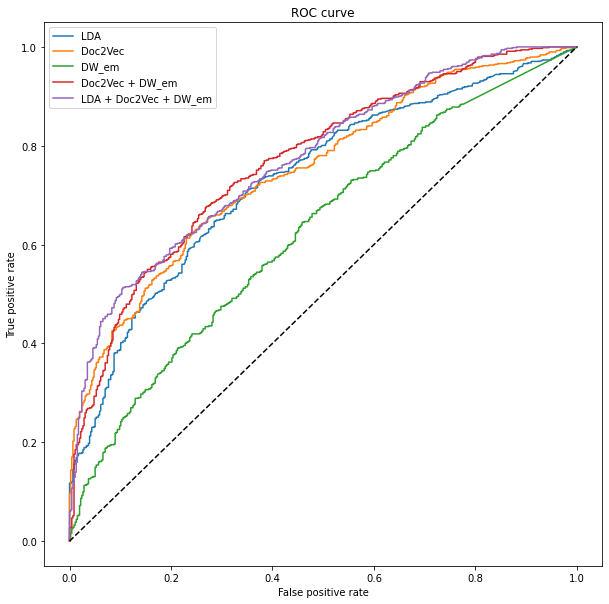

<Figure size 720x720 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(fpr_xgboost_LDA, tpr_xgboost_LDA, label='LDA')
plt.plot(fpr_xgboost_Doc2Vec, tpr_xgboost_Doc2Vec, label='Doc2Vec')
plt.plot(fpr_xgboost_gem, tpr_xgboost__gem, label='DW_em')
plt.plot(fpr_xgboost_Doc2Vec_gem, tpr_xgboost_Doc2Vec_gem, label='Doc2Vec + DW_em')
plt.plot(fpr_xgboost_Doc2Vec_gem_LDA, tpr_xgboost_Doc2Vec_gem_LDA, label='LDA + Doc2Vec + DW_em')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig1 = plt.gcf()
plt.plot([0, 1], [0, 1], 'k--')
plt.show()
plt.draw()
#fig1.savefig('new_data_roc.png', dpi=100)

In [17]:
features = F_Doc2Vec + F_gem + F_LDA
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train[features],y_train)

preds = xg_reg.predict(X[features])
len(preds)

[22:06:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


5686

In [18]:
X_toprint = X[['title', 'journal', 'DOI', 'date', 'collection',
       'published', 'nauthors', 'topic.Healthcare', 'topic.Drug discovery',
       'topic.Epidemiology', 'topic.Clinics', 'topic.Chest X-Ray',
       'topic.Genomics', 'topic', 'numcit', 'influcit', 'DL_Pdf', 'DL_Full',
       'DL_Abstract', 'cit', 'cit_velocity', 'influential_cit', 'sum.npapers',
       'sum.infCit', 'mean.npapers', 'mean.infCit', 'max.npapers',
       'max.infCit','pubmed', 'medrxiv', 'arxiv', 'biorxiv']]

X_toprint['title'] = X_toprint['title'].replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n',  ' ', regex=True)

/Users/xuxiaopeng/opt/anaconda3/envs/ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [19]:
X_toprint['pred_pub_prob'] = preds

/Users/xuxiaopeng/opt/anaconda3/envs/ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
X_toprint.to_csv('./data/lda_cit_authmet.csv')